<a href="https://colab.research.google.com/github/ytg000629/ai4dl/blob/main/project/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치,import, 데이터 준비



In [10]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import wordcloud
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import os 
import warnings
warnings.filterwarnings(action  = 'ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from autocorrect import Speller 

In [15]:
#%config Completer.use_jedi = False

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
df_train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
df_test = pd.read_csv('drive/MyDrive//nlp-getting-started/test.csv')
df_sample = pd.read_csv('drive/MyDrive//nlp-getting-started/sample_submission.csv')

In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_train.shape

(7613, 5)

In [20]:
df_test.shape

(3263, 4)

In [21]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [ ]:
def create_corpus(target):
    corpus = []
    for x in df_train[df_train["target"] == target]["text"].str.split():
        print(x)
        for i in x:
            corpus.append(i)
            
    return corpus

In [ ]:
corpus = create_corpus(0)

stop = set(stopwords.words("english"))

dictionary = defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary[word] +=1
        
top = sorted(dictionary.items(), key = lambda x:x[1], reverse=True)[:10]

Text(0.5, 1.0, 'top words 0')

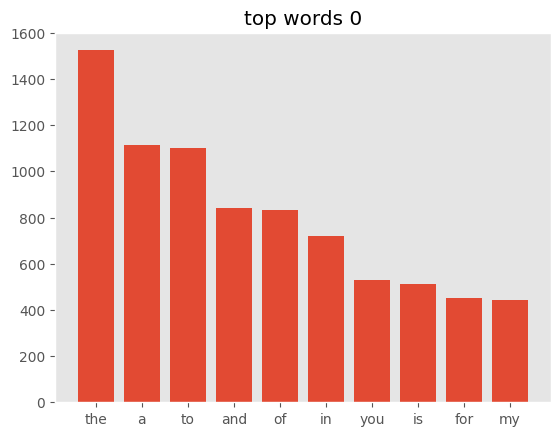

In [ ]:
x, y = zip(*top)

plt.grid()
plt.bar(x,y)
plt.title("top words 0")

In [ ]:
corpus = create_corpus(1)

stop = set(stopwords.words("english"))

dictionary = defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary[word] +=1
        
top = sorted(dictionary.items(), key = lambda x:x[1], reverse=True)[:10]

Text(0.5, 1.0, 'top words 1')

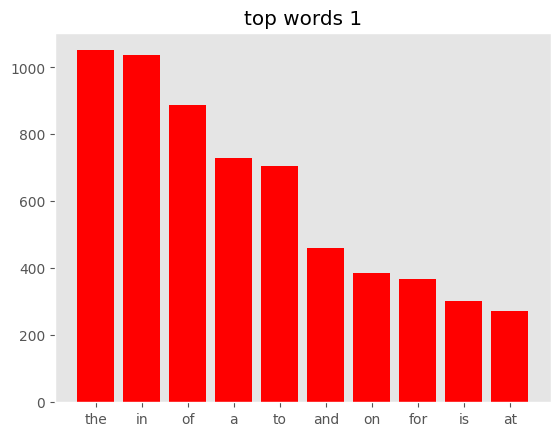

In [ ]:
x, y = zip(*top)

plt.grid()
plt.bar(x,y, color = 'r')
plt.title("top words 1")

In [ ]:
corpus = create_corpus(1)

dictionary = defaultdict(int)

import string

special_char = string.punctuation

for i in corpus:
    if i in special_char:
        dictionary[i] +=1

Text(0.5, 1.0, 'Punctuation disaster 1')

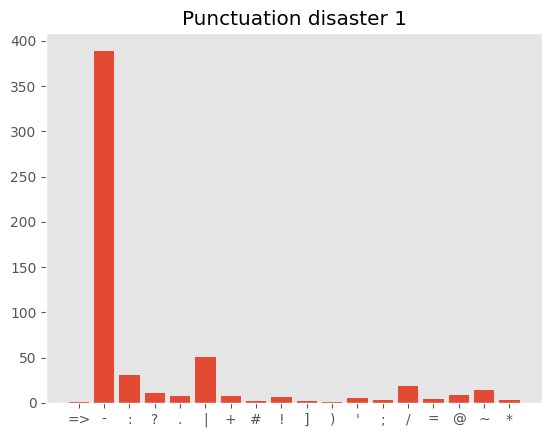

In [ ]:
x,y = zip(*dictionary.items())

plt.grid()
plt.bar(x,y)
plt.title("Punctuation disaster 1")

In [ ]:
corpus = create_corpus(0)

dictionary = defaultdict(int)

import string

special_char = string.punctuation

for i in corpus:
    if i in special_char:
        dictionary[i] +=1

Text(0.5, 1.0, 'Punctuation disaster 0')

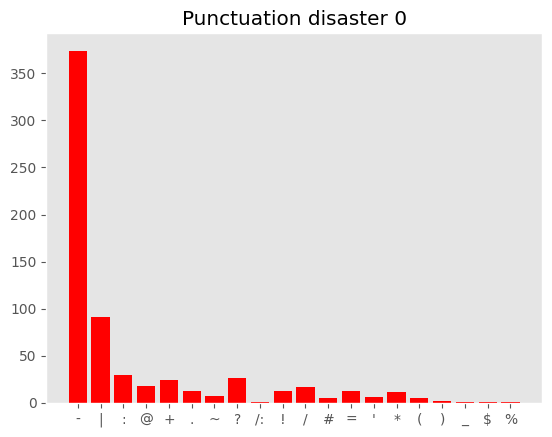

In [ ]:
x,y = zip(*dictionary.items())

plt.grid()
plt.bar(x,y, color = 'r')
plt.title("Punctuation disaster 0")

In [ ]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []

for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

<Axes: title={'center': 'most common words'}>

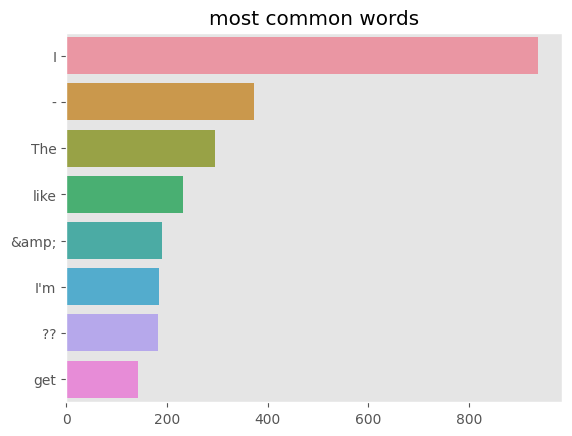

In [ ]:
plt.title("most common words")
plt.grid()
sns.barplot(x = y, y = x)

# 데이터 전처리

In [29]:
import emoji
stop=set(stopwords.words('english'))

def text_preproccessing(df):  
    
    df = df.copy()
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def remove_stopwords(x):
        return ' '.join([i for i in x.split() if i not in stop])

    def spell_check(x):
        spell = Speller(lang='en')
        return " ".join([spell(i) for i in x.split()])

    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text']=df['text'].apply(lambda x : remove_emoji(x))
    df['text']=df['text'].apply(lambda x : remove_stopwords(x))
    #df['text']=df['text'].apply(lambda x : spell_check(x))

    return df


In [30]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

In [31]:
df_train.shape

(7613, 5)

In [32]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked shelter place notified off...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1


In [33]:
df_test.shape

(3263, 4)

In [34]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan


In [35]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 5)

#  simple RNN

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X_train_encoded = tokenizer.texts_to_sequences(df['text']) #단어를 숫자로

print(X_train_encoded[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
word_to_index = tokenizer.word_index
print(word_to_index)

In [ ]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 1인 것들 개수 카운트
total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 1인 것들의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 14308
단어 집합(vocabulary)에서 희귀 단어의 비율: 62.77090462402387
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.831596506017615


In [ ]:
a = []
for i in range(len(X_train_encoded)):
    a.append(len(X_train_encoded[i]))
max(a)

#가장 긴 tweet의 길이 : 28개의 단어

28

In [ ]:
tokenizer.word_counts.items()
#등장 빈도가 1번인 애들 살펴보기

In [ ]:
total_cnt - rare_cnt + 1

8487

# RNN 한번만 나오는 단어 제거

In [ ]:
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)    #한번만 나오는 단어 제거, 단어 빈도가 많은 순서로 5767개 단어 보존
tokenizer.fit_on_texts(df['text'])                             #key value로 이루어진 딕셔너리 만들기    
X_train_encoded = tokenizer.texts_to_sequences(df['text'])     #단어를 숫자로

print(X_train_encoded[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 1354], [123, 1522, 1434, 2187, 665, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 142]]


In [ ]:
a = []
for i in range(len(X_train_encoded)):
    a.append(len(X_train_encoded[i]))
max(a)

#등장 빈도 1번인 애들 제거 후 가장 긴 tweet의 길이 : 26개의 단어

26

In [ ]:
max_len = 26
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (10876, 26)


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8487


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train_padded[:df_train.shape[0]], df_train['target'].values, test_size=0.2, random_state=0, stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
        patience=5,         # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5609
Epoch 1: val_accuracy improved from -inf to 0.57058, saving model to checkpoint_path.keras
96/96 [==============================] - 22s 159ms/step - loss: 0.6826 - accuracy: 0.5609 - val_loss: 0.6749 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.5993
Epoch 2: val_accuracy improved from 0.57058 to 0.60473, saving model to checkpoint_path.keras
96/96 [==============================] - 11s 117ms/step - loss: 0.6633 - accuracy: 0.5993 - val_loss: 0.6629 - val_accuracy: 0.6047 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.6381 - accuracy: 0.6654
Epoch 3: val_accuracy improved from 0.60473 to 0.64150, saving model to checkpoint_path.keras
96/96 [==============================] - 5s 54ms/step - loss: 0.6381 - accuracy: 0.6654 - val_loss: 0.6437 - val_accuracy: 0.6415 - lr: 1.000

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

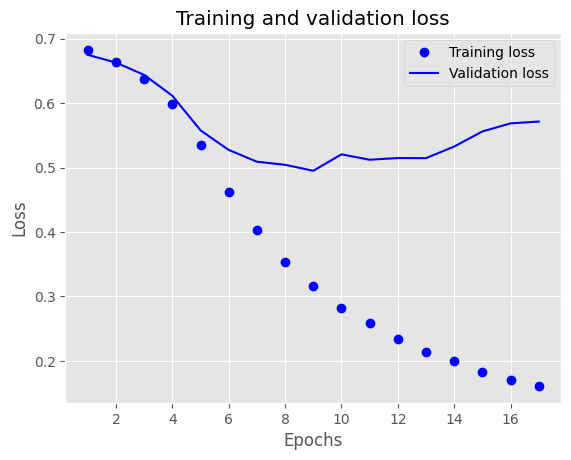

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

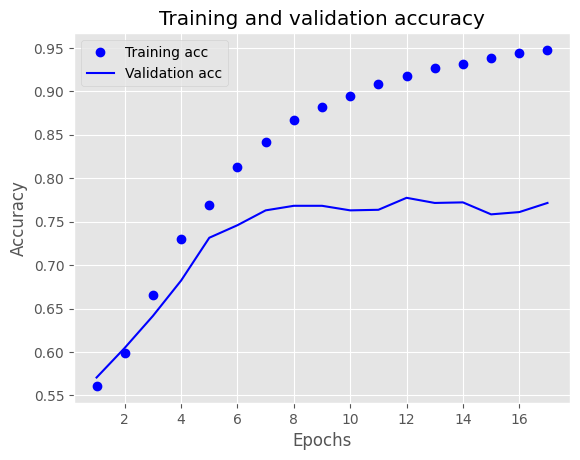

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(X_train_padded[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 

102/102 [==============================] - 1s 5ms/step


#RNN 한번만 나오는 단어 제거 X

In [ ]:
tokenizer = Tokenizer()                                        #한번만 나오는 단어 제거X
tokenizer.fit_on_texts(df['text'])                             #key value로 이루어진 딕셔너리 만들기    
X_train_encoded = tokenizer.texts_to_sequences(df['text'])     #단어를 숫자로

print(X_train_encoded[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
a = []
for i in range(len(X_train_encoded)):
    a.append(len(X_train_encoded[i]))
max(a)

#등장 빈도 1번인 애들 제거 후 가장 긴 tweet의 길이 : 28개의 단어

28

In [ ]:
max_len = 28
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (10876, 28)


In [ ]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22795


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train_padded[:df_train.shape[0]], df_train['target'].values, test_size=0.2, random_state=0, stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
        patience=5,         # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.5634
Epoch 1: val_accuracy improved from -inf to 0.57321, saving model to checkpoint_path.keras
96/96 [==============================] - 20s 189ms/step - loss: 0.6785 - accuracy: 0.5634 - val_loss: 0.6735 - val_accuracy: 0.5732 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6141
Epoch 2: val_accuracy improved from 0.57321 to 0.62443, saving model to checkpoint_path.keras
96/96 [==============================] - 11s 111ms/step - loss: 0.6574 - accuracy: 0.6141 - val_loss: 0.6567 - val_accuracy: 0.6244 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.7016
Epoch 3: val_accuracy improved from 0.62443 to 0.68155, saving model to checkpoint_path.keras
96/96 [==============================] - 5s 53ms/step - loss: 0.6226 - accuracy: 0.7016 - val_loss: 0.6298 - val_accuracy: 0.6815 - lr: 1.000

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

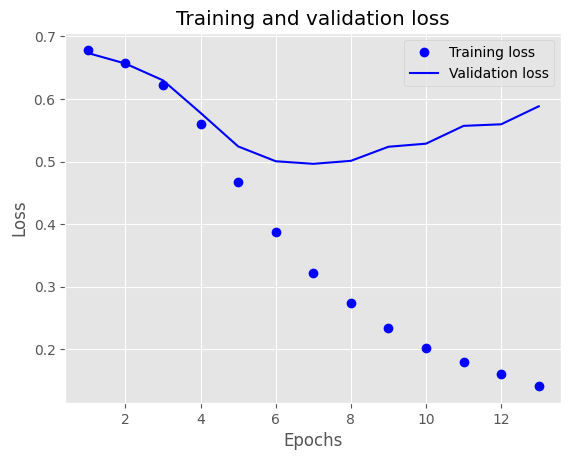

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

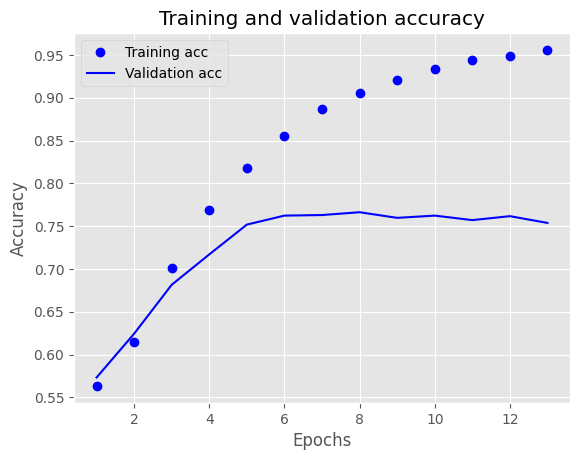

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(X_train_padded[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 

102/102 [==============================] - 1s 4ms/step


# LSTM

In [ ]:
tokenizer = Tokenizer()                                        
tokenizer.fit_on_texts(df['text'])                                
X_train_encoded = tokenizer.texts_to_sequences(df['text'])     

print(X_train_encoded[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
a = []
for i in range(len(X_train_encoded)):
    a.append(len(X_train_encoded[i]))
max(a)

#가장 긴 tweet의 길이 : 28개의 단어

28

In [ ]:
max_len = 28
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (10876, 28)


In [ ]:
vocab_size = len(word_to_index)
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22794


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train_padded[:df_train.shape[0]], df_train['target'].values, test_size=0.2, random_state=0, stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Bidirectional
from tensorflow.keras.models import Sequential

embedding_dim = 128


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
        patience=5,          # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5691
Epoch 1: val_accuracy improved from -inf to 0.57058, saving model to checkpoint_path.keras
96/96 [==============================] - 22s 150ms/step - loss: 0.6814 - accuracy: 0.5691 - val_loss: 0.6716 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.6668
Epoch 2: val_accuracy improved from 0.57058 to 0.77544, saving model to checkpoint_path.keras
96/96 [==============================] - 7s 74ms/step - loss: 0.6169 - accuracy: 0.6668 - val_loss: 0.5235 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8504
Epoch 3: val_accuracy improved from 0.77544 to 0.79383, saving model to checkpoint_path.keras
96/96 [==============================] - 4s 37ms/step - loss: 0.3744 - accuracy: 0.8504 - val_loss: 0.4772 - val_accuracy: 0.7938 - lr: 1.0000e

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

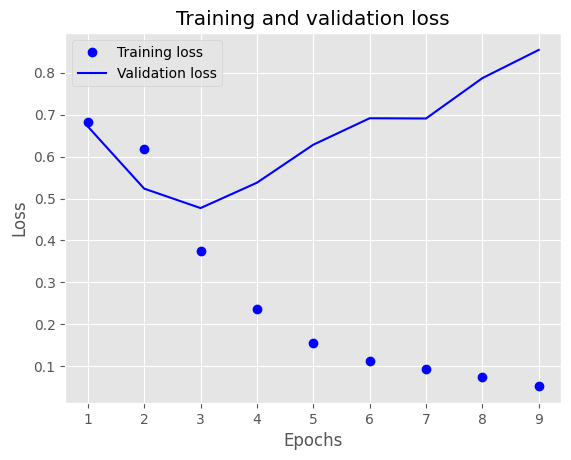

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

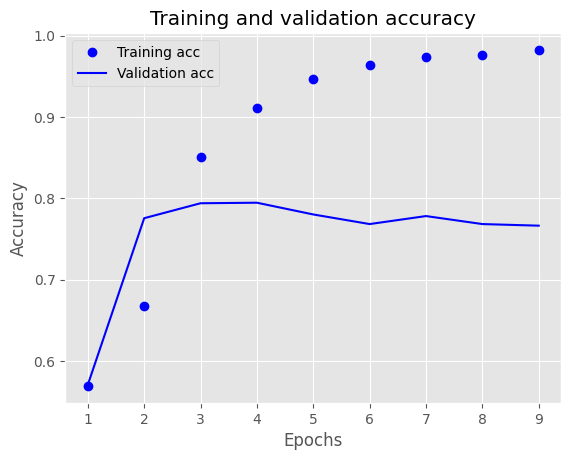

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(X_train_padded[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 

102/102 [==============================] - 2s 5ms/step


# GLOVE

In [63]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [64]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:00<00:00, 11093.85it/s]


In [65]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

#pre-trained word embedding download
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [66]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    #100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [67]:
embedding_dict['described']
#임의의 단어의 임베딩 벡터

array([-0.77675  , -0.39544  , -0.23503  ,  0.12374  , -0.062412 ,
        0.16114  ,  0.41224  , -0.1183   , -0.24595  , -0.0042676,
       -0.46711  , -0.1773   ,  0.22936  , -0.15351  ,  0.19196  ,
        0.3456   ,  0.19291  , -0.48402  , -0.62981  , -0.05973  ,
        0.30394  , -0.20145  ,  0.12788  , -0.29756  ,  0.014653 ,
       -0.042935 , -0.097113 ,  0.043257 ,  0.02393  ,  0.73688  ,
        0.22381  ,  0.18879  , -0.30323  ,  0.012293 ,  0.29425  ,
        0.24309  ,  0.048583 ,  0.26707  , -0.056675 , -0.10544  ,
       -0.80896  ,  0.23054  ,  0.70457  ,  0.37263  , -0.036724 ,
       -0.23211  ,  0.12504  ,  0.044823 , -0.060565 , -0.14451  ,
        0.66952  , -0.42189  ,  0.94151  ,  0.78102  , -0.50328  ,
       -2.0984   , -0.18119  , -0.18671  ,  0.6576   ,  0.55676  ,
       -0.081965 ,  0.61956  , -0.18996  , -0.38323  ,  0.94778  ,
       -0.45197  ,  0.62815  ,  0.42958  ,  0.20367  ,  0.18164  ,
       -0.2055   ,  0.35146  , -0.19534  , -0.034256 ,  0.2947

In [68]:
print('벡터의 차원 수 :',len(embedding_dict['described']))

벡터의 차원 수 : 100


In [69]:
MAX_LEN=28
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)

sequences=tokenizer_obj.texts_to_sequences(corpus)

pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [70]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [71]:
num_words=len(word_index)
print(num_words)

20342


In [72]:
embedding_matrix = np.zeros((num_words, 100))

In [73]:
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 610225.66it/s]


In [74]:
embedding_matrix.shape

(20342, 100)

In [75]:
pad[0][0:]

array([ 622, 5467,  738,  175,   80, 1805, 3529,   16,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [76]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Bidirectional
from tensorflow.keras.models import Sequential

model=Sequential()

output_dim = 100
embedding=Embedding(num_words,output_dim,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
        patience=5,          # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
)
]

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 100)           2034200   
                                                                 
 bidirectional (Bidirectiona  (None, 28, 256)          234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,441,369
Trainable params: 407,169
Non-tr

In [78]:
train_data, val_data, train_labels, val_labels = train_test_split(pad[:df_train.shape[0]], df_train['target'].values, test_size=0.2, stratify=df_train['target'].values, random_state=10)

print('Shape of train',train_data.shape)
print("Shape of Validation ",val_data.shape)

Shape of train (6090, 28)
Shape of Validation  (1523, 28)


In [79]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5992
Epoch 1: val_accuracy improved from -inf to 0.62640, saving model to checkpoint_path.keras
96/96 [==============================] - 13s 40ms/step - loss: 0.6852 - accuracy: 0.5995 - val_loss: 0.6762 - val_accuracy: 0.6264 - lr: 1.0000e-05
Epoch 2/50
93/96 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6428
Epoch 2: val_accuracy improved from 0.62640 to 0.67892, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 33ms/step - loss: 0.6667 - accuracy: 0.6448 - val_loss: 0.6564 - val_accuracy: 0.6789 - lr: 1.0000e-05
Epoch 3/50
93/96 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.7016
Epoch 3: val_accuracy improved from 0.67892 to 0.74590, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 29ms/step - loss: 0.6438 - accuracy: 0.7028 - val_loss: 0.6296 - val_accuracy: 0.7459 - lr: 1.0000e-

In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

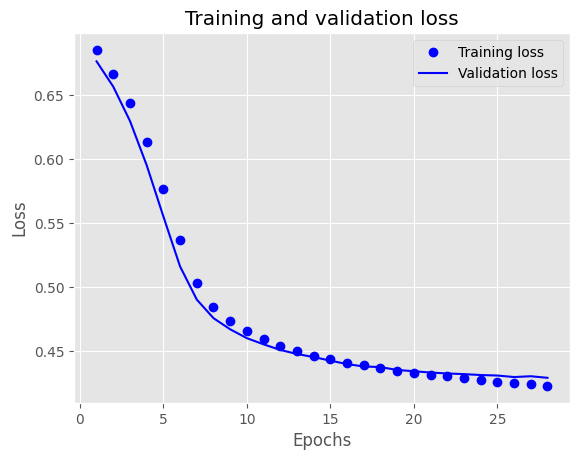

In [81]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

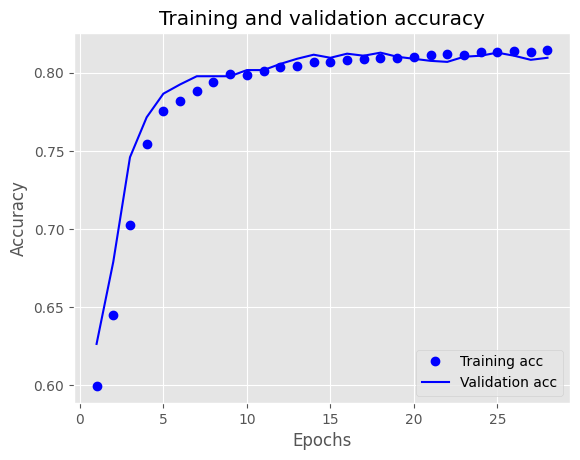

In [82]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [83]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(pad[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 0.79098

102/102 [==============================] - 2s 5ms/step


In [84]:
b = df_sample['target']

In [85]:
b

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    0
Name: target, Length: 3263, dtype: int64

# BERT

In [86]:
max_length = max([len(sent.split()) for sent in df.text ])
print(max_length)

28


In [87]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.4 MB/s eta 0:00:00


In [88]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [89]:
#train_data, val_data, train_labels, val_labels = train_test_split(df_train.text.values, df_train.target.values, test_size=0.2, random_state=10)
train_data, val_data, train_labels, val_labels = train_test_split(df['text'][:df_train.shape[0]].values, df_train['target'].values, test_size=0.2, stratify=df_train['target'].values, random_state=10)

In [90]:
train_data = tokenizer(
text = train_data.tolist(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [91]:
train_data

{'input_ids': <tf.Tensor: shape=(6090, 28), dtype=int32, numpy=
array([[  101,  2610,  3102, ...,     0,     0,     0],
       [  101,  1049,  2232, ...,     0,     0,     0],
       [  101, 11352,  5856, ...,     0,     0,     0],
       ...,
       [  101, 12632,  3521, ...,     0,     0,     0],
       [  101,  2017,  4148, ...,     0,     0,     0],
       [  101,  2018,  3167, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 28), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [92]:
val_data = tokenizer(
text = val_data.tolist(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

##Model

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [94]:
max_len = 28


input_ids = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [95]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 28)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 28)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 28,                                          

In [96]:
train_data['input_ids']

<tf.Tensor: shape=(6090, 28), dtype=int32, numpy=
array([[  101,  2610,  3102, ...,     0,     0,     0],
       [  101,  1049,  2232, ...,     0,     0,     0],
       [  101, 11352,  5856, ...,     0,     0,     0],
       ...,
       [  101, 12632,  3521, ...,     0,     0,     0],
       [  101,  2017,  4148, ...,     0,     0,     0],
       [  101,  2018,  3167, ...,     0,     0,     0]], dtype=int32)>

In [97]:
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')


model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
        patience=5,          # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
)
]

In [98]:
history = model.fit(
    x ={'input_ids':train_data['input_ids'],'input_mask':train_data['attention_mask']} ,
    y = train_labels,
    validation_data = ({'input_ids':val_data['input_ids'],'input_mask':val_data['attention_mask']},val_labels),
    callbacks=callbacks_list,
    #validation_split = 0.1,
    epochs=50,
    batch_size=32
)

Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7187
Epoch 1: val_accuracy improved from -inf to 0.78267, saving model to checkpoint_path.keras
191/191 [==============================] - 106s 440ms/step - loss: 0.5704 - accuracy: 0.7187 - val_loss: 0.4843 - val_accuracy: 0.7827 - lr: 6.0000e-06
Epoch 2/50
191/191 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8064
Epoch 2: val_accuracy improved from 0.78267 to 0.81550, saving model to checkpoint_path.keras
191/191 [==============================] - 62s 326ms/step - loss: 0.4546 - accuracy: 0.8064 - val_loss: 0.4259 - val_accuracy: 0.8155 - lr: 6.0000e-06
Epoch 3/50
191/191 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8238
Epoch 3: val_accuracy did not improve from 0.81550
191/191 [==============================] - 46s 241ms/step - loss: 0.4174 - accuracy: 0.8238 - val_loss: 0.4223 - val_accuracy: 0.8135 - lr: 6.0000e-06
Epoch 4/50
191/191 [==

KeyboardInterrupt: ignored

In [99]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras', custom_objects={"TFBertModel": TFBertModel})

In [100]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

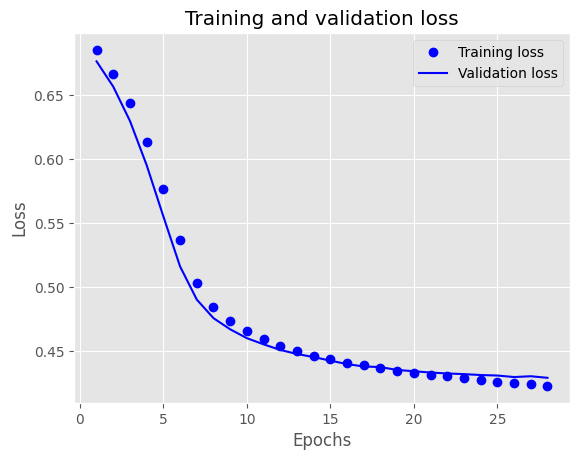

In [101]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

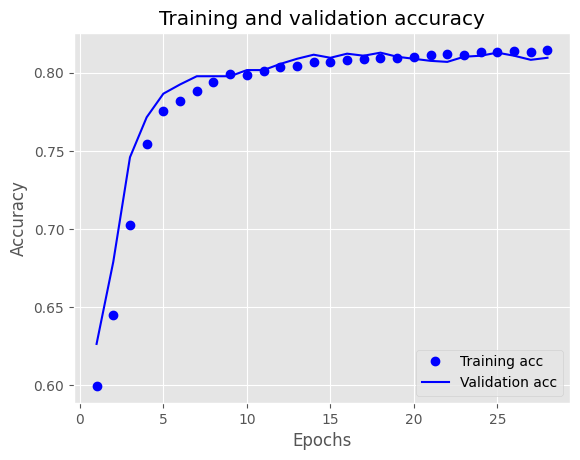

In [102]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [103]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [104]:
x_test['attention_mask']

<tf.Tensor: shape=(3263, 28), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [105]:
predicted = loaded_model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

102/102 [==============================] - 10s 76ms/step


In [106]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
# 리더보드 0.82929

In [107]:
c = df_sample['target']
c

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64

# BERT - StratifiedKFold CV

# roBerta

In [37]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [26]:
#!pip install tokenization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#!pip install bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3745 sha256=06e1f08379158eac5799c35bda6a6f0467d3ec4416dbe4d87820a7646eaf1962
  Stored in directory: /root/.cache/pip/wheels/d0/97/c8/5775d57c323970511488d9b53ce66cf0ded394fe4b4f6e0afb
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6777 sha256=a70345ab00e11323321528070702033b2da8cc793c4c4042a82fd7fc9c92a098
  Stored in directory: /root/.cache/pip/wheels/f5/ca/b1/ce71c2e0e9e0df3786697d06d53574be03ef86cd4fb0e2cb99
Successfully built bert erlastic


In [1]:
!pip install bert-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [40]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #could be pooled_output, sequence_output yet sequence output provides for each input token (in context)
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    #specifying optimizer
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [41]:
from bert import tokenization

In [43]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [44]:
#vocab file from pre-trained BERT for tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#returns true/false depending on if we selected cased/uncased bert layer
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#Create the tokenizer
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

#tokenizing the training and testing data
train_input = bert_encode(df_train.text.values, tokenizer, max_len=160)
test_input = bert_encode(df_test.text.values, tokenizer, max_len=160)
train_labels = df_train.target.values

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',       

In [49]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.1,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/3
429/429 [==============================] - 839s 2s/step - loss: 0.4362 - accuracy: 0.8116 - val_loss: 0.4043 - val_accuracy: 0.8307
Epoch 2/3
429/429 [==============================] - 709s 2s/step - loss: 0.3544 - accuracy: 0.8488 - val_loss: 0.4086 - val_accuracy: 0.8268
Epoch 3/3
429/429 [==============================] - 699s 2s/step - loss: 0.2755 - accuracy: 0.8867 - val_loss: 0.4799 - val_accuracy: 0.8268


In [50]:
test_pred = model.predict(test_input)
df_sample['target'] = test_pred.round().astype(int)
df_sample.to_csv('submission.csv', index=False)
#리더보드 0.825

102/102 [==============================] - 124s 1s/step


NameError: ignored

In [54]:
a = df_sample['target']

In [60]:
a

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64

In [108]:
b

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    0
Name: target, Length: 3263, dtype: int64

In [109]:
c

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64

In [111]:
d = (a+b+c)/3
d

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
3258    1.000000
3259    1.000000
3260    1.000000
3261    1.000000
3262    0.666667
Name: target, Length: 3263, dtype: float64

In [112]:
e = np.where(d >= 0.5, 1, 0)
e

array([1, 1, 1, ..., 1, 1, 1])

In [113]:
df_sample['target'] = e
df_sample.to_csv('submission.csv', index=False)
#리더보드 0.825